# Section 4 - Trajectory Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# System utilities
import os
import pickle
from pathlib import Path
from datetime import datetime
import warnings
import time
import math

# Data handling and numerical computation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
from upsetplot import UpSet, from_memberships
from plot_utils import proportion
from utils import plot_upset
from utils import scatter_df
import matplotlib.ticker as ticker

# Single-cell analysis and related packages
import anndata as ad
import scanpy as sc
import squidpy as sq

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='numpy')
warnings.filterwarnings('ignore', category=FutureWarning, module='scanpy')
warnings.filterwarnings('ignore', category=UserWarning, module='scanpy')
warnings.filterwarnings('ignore', category=UserWarning, module='numpy')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Performance
from joblib import Parallel, delayed

# Function to print the current time with a message
def print_with_time(message):
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] {message}")

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['pdf.fonttype'] = 42  # Ensures text is stored as text, not paths
plt.rcParams['ps.fonttype'] = 42


C:\Users\ard212.PITT\Anaconda3\envs\py311\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
C:\Users\ard212.PITT\Anaconda3\envs\py311\Lib\site-packages\xarray_schema\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
C:\Users\ard212.PITT\Anaconda3\envs\py311\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [5]:
import gseapy as gp

In [6]:
import scanpy.external as sce
import phate

In [7]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import Polygon
from shapely.ops import unary_union

def convert2gpd(df):
    # Step 1: Group the DataFrame by 'cell_id' or similar, assuming each cell has a unique ID
    # Ensure that your DataFrame has an identifier for each cell
    grouped = df.groupby('cell_id')

    # Step 2: Create polygons for each group of cell boundaries
    polygons = []

    for cell_id, group in grouped:
        # Extract the x and y coordinates for this cell
        points = group[['vertex_x', 'vertex_y']].values
        
        # Create a Polygon from these points
        # Ensure the points form a valid polygon (e.g., no crossing lines)
        if len(points) > 2:  # A polygon needs at least 3 points
            poly = Polygon(points)
            polygons.append({'cell_id': cell_id, 'geometry': poly})

    # Step 3: Create a GeoPandas DataFrame from the list of polygons
    gdf = gpd.GeoDataFrame(polygons)
    return gdf

In [8]:

def plot_color_palette(color_dict, title, pdf):
    labels = list(color_dict.keys())
    colors = list(color_dict.values())
    num_colors = len(colors)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(5, num_colors // 2))

    # Plot each color as a horizontal bar
    for i, (label, color) in enumerate(zip(labels, colors)):
        ax.barh(i, 1, color=color)
        ax.text(0.5, i, label, va='center', ha='center', fontsize=10, color='white', fontweight='bold')

    # Remove axes
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Set title
    ax.set_title(title, fontweight='bold')

    # Save the current figure to the PDF
    if pdf:
        pdf.savefig(fig)
    plt.show()
    plt.close(fig)

In [7]:
# Process samples
samples = ['KS_TMA_1_0026870', 'KS_TMA_2_0026882', 'KS_TMA_3_0027198', 'KS_TMA_4_0026764', 'KS_TMA_5_0026776',
           'KS_TMA_6_0027092', 'KS_TMA_7_0027079', 'KS_TMA_8_0027273', 'KS_TMA_9_0026831', 'KS_TMA_10_0026828',
           'KS_TMA_11_0026930', 'KS_TMA_12_0026888', 'KS_TMA_13_0027077', 'KS_TMA_14_0027019', 'KS_TMA_15_0033811',
          'KS_TMA_16_0033809']

marker_list_df_all = pd.read_csv('data/marker_list_dev_standardized_short.csv')
marker_list_df = marker_list_df_all.copy()
marker_list_df = marker_list_df.query(f"Annotation not in ['Vascular Endothelial Cells', 'Lymphatic Endothelial Cells']")

# Define cell types and clusters
cell_types = list(marker_list_df.keys())

marker_list = marker_list_df
marker_list = marker_list.groupby('grouped_cts')['Gene'].unique().reset_index()
marker_list = marker_list.set_index('grouped_cts')['Gene'].apply(list).to_dict()

complete_cell_types = list(marker_list_df['grouped_cts'].unique())
marker_genes_dict = marker_list

In [8]:
marker_genes_dict.keys()

dict_keys(['B-cells', 'Basal to Spinous Cells', 'Cycling Cells', 'Dendritic cells', 'Eccrine Cells', 'Endothelial Cells', 'Erythrocytes', 'Fibroblasts', 'Keratinocytes', 'Macrophages', 'Melanocytes', 'Nk Cells', 'Pericytes', 'Pilosebaceous Cells', 'Spinous to Granular Cells', 'T-cells'])

In [9]:
marker_genes_dict['Macrophages']

['AIF1',
 'BASP1',
 'C15orf48',
 'C1QA',
 'C5AR1',
 'CD68',
 'CD83',
 'CD93',
 'COTL1',
 'CTSZ',
 'FCER1G',
 'GPR183',
 'HMGB2',
 'HMGN2',
 'ID2',
 'IL1B',
 'INHBA',
 'INSIG1',
 'IRF4',
 'LYZ',
 'RGS1',
 'STMN1',
 'TSPAN33',
 'TYROBP']

In [10]:
# Process samples
samples = ['KS_TMA_1_0026870', 'KS_TMA_2_0026882', 'KS_TMA_3_0027198', 'KS_TMA_4_0026764', 'KS_TMA_5_0026776',
           'KS_TMA_6_0027092', 'KS_TMA_7_0027079', 'KS_TMA_8_0027273', 'KS_TMA_9_0026831', 'KS_TMA_10_0026828', 
           'KS_TMA_11_0026930', 'KS_TMA_12_0026888', 'KS_TMA_13_0027077', 'KS_TMA_14_0027019', 'KS_TMA_15_0033811',
          'KS_TMA_16_0033809']

adata = sc.read_h5ad('data/spatial_single_cell_KS_adata.h5ad')

adata.obsm["spatial"] = adata.obs[["local_x", "local_y"]].copy().to_numpy()

In [11]:
KS_lytic_genes = ['KSHV.ORF50', 'KSHV.ORF57', 'KSHV.ORF59', 'KSHV.K9', 'KSHV.ORF65'] 
KS_latent_genes = ['KSHV.ORF71','KSHV.ORF72','KSHV.ORF73',] 
KS_K2_gene = ['KSHV.K2']

nctc_neighbors = 30
n_clusters = 10

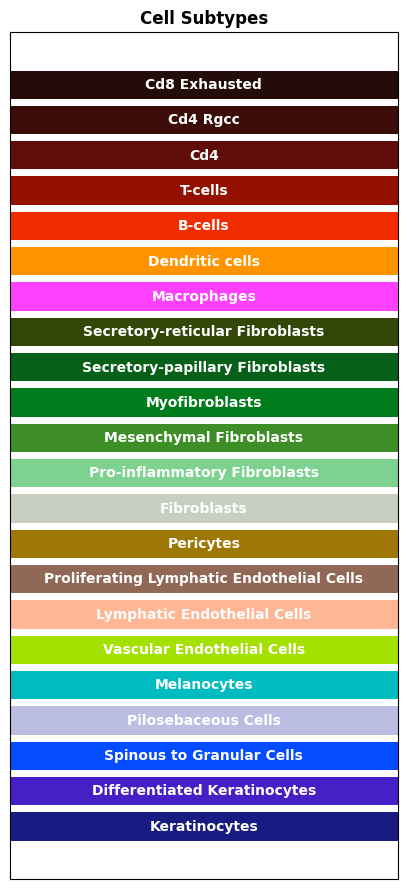

In [12]:
sub_cell_types_color_mapping = {
    'Keratinocytes': '#181c82',
    'Differentiated Keratinocytes': '#471fc7',
    'Spinous to Granular Cells': '#034cff',
    'Pilosebaceous Cells': '#bbbde2',
    'Melanocytes': '#00bbbf',

    'Vascular Endothelial Cells': '#a4e000',
    'Lymphatic Endothelial Cells': '#ffb695',
    'Proliferating Lymphatic Endothelial Cells': '#906855',
    'Pericytes': '#9f7704',
    
    'Fibroblasts': '#c7d0c0',
    'Pro-inflammatory Fibroblasts': '#7cd28e',
    'Mesenchymal Fibroblasts': '#3d8e27',
    'Myofibroblasts': '#007c1d',
    'Secretory-papillary Fibroblasts': '#076018',
    'Secretory-reticular Fibroblasts': '#324708',
    
    'Macrophages': '#ff40ff',
    'Dendritic cells': '#ff9300',
    'B-cells': '#f12d00',
    'T-cells': '#941100',
    'Cd4': '#600c09',
    'Cd4 Rgcc': '#3c0c09',
    'Cd8 Exhausted': '#240c09',
}


with PdfPages('figures/sub_cell_types_color_mapping.pdf') as pdf:
    plot_color_palette(sub_cell_types_color_mapping, "Cell Subtypes", pdf)

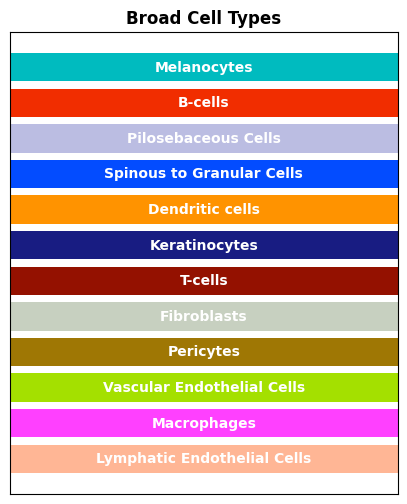

In [13]:
broad_cell_types_color_mapping = {\
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages': '#ff40ff',
    'Vascular Endothelial Cells': '#a4e000',
    'Pericytes': '#9f7704',
    'Fibroblasts': '#c7d0c0',
    'T-cells': '#941100',
    'Keratinocytes': '#181c82',
    'Dendritic cells': '#ff9300',
    'Spinous to Granular Cells': '#034cff',
    'Pilosebaceous Cells': '#bbbde2',
    'B-cells': '#f12d00',
    'Melanocytes': '#00bbbf'
}

with PdfPages('figures/broad_cell_types_color_mapping.pdf') as pdf:
    plot_color_palette(broad_cell_types_color_mapping, "Broad Cell Types", pdf)

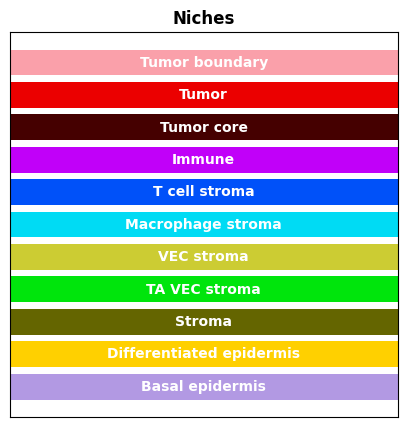

In [9]:
niche_colors = {
    "Basal epidermis": "#b299e3",
    "Differentiated epidermis": "#ffd000",
    "Stroma": "#646500",
    "TA VEC stroma": "#00e50c",
    "VEC stroma": "#cccc33",
    "Macrophage stroma": "#00dbf4",
    "T cell stroma": "#0051f9",
    "Immune": "#c100f9",
    "Tumor core": "#450000",
    "Tumor": "#eb0000",
    "Tumor boundary": "#faa0aa"
}


with PdfPages('figures/niches_color_mapping.pdf') as pdf:
    plot_color_palette(niche_colors, "Niches", pdf)

In [16]:
import pandas as pd
import numpy as np

# Step 1: Extract relevant data from the AnnData object
# Assuming adata.obs contains 'path_block_core', 'broad_cell_types', and 'Stage'
df = adata.obs[['path_block_core', 'broad_cell_types', 'Stage']].copy()

# Step 2: Count occurrences of each cell type per sample and stage
cell_counts = df.groupby(['Stage', 'path_block_core', 'broad_cell_types']).size().unstack(fill_value=0)

# Step 3: Calculate proportions
cell_counts['Lymphatic'] = cell_counts.get('Lymphatic Endothelial Cells', 0)
cell_counts['Vascular'] = cell_counts.get('Vascular Endothelial Cells', 0)

# Avoid division by zero
cell_counts['Proportion'] = np.where(cell_counts['Vascular'] > 0,
                                     cell_counts['Lymphatic'] / cell_counts['Vascular'],
                                     0)

# Step 4: Group by Stage and list samples with their proportions
proportions_by_stage = cell_counts.groupby('Stage')['Proportion'].agg(list).reset_index()

In [17]:
import pandas as pd
import numpy as np

# Step 1: Extract relevant data from the AnnData object
df = adata.obs[['path_block_core', 'broad_cell_types', 'Stage']].copy()

# Step 2: Count occurrences of each cell type per sample and stage
cell_counts = df.groupby(['Stage', 'path_block_core', 'broad_cell_types']).size().unstack(fill_value=0)

# Step 3: Calculate proportions
cell_counts['Lymphatic'] = cell_counts.get('Lymphatic Endothelial Cells', 0)
cell_counts['Vascular'] = cell_counts.get('Vascular Endothelial Cells', 0)

# Avoid division by zero and calculate proportions
cell_counts['Proportion'] = np.where(cell_counts['Vascular'] > 0,
                                     cell_counts['Lymphatic'] / cell_counts['Vascular'],
                                     0)

# Step 4: Create a DataFrame with 'Stage', 'path_block_core', and 'Proportion' columns
proportions_df = cell_counts[['Proportion']].reset_index()

# Step 5: Drop rows where Proportion is zero
proportions_df = proportions_df[proportions_df['Proportion'] != 0]

# Step 6: Set 'path_block_core' as the index
proportions_df.set_index('path_block_core', inplace=True)

# Check the range of Proportion values
min_proportion = proportions_df['Proportion'].min()
max_proportion = proportions_df['Proportion'].max()
print(f"Minimum Proportion: {min_proportion}, Maximum Proportion: {max_proportion}")

# Step 7: Create bins for the Proportion column
# Define the bins based on the range of Proportion
bins = [0, 0.1, 1, 5, 10, 20, 30, 40]  # Adjust these values based on your analysis needs
labels = range(len(bins) - 1)  # Bin IDs (0, 1, 2, ...)

# Create a new column 'Bin_ID' based on the 'Proportion'
proportions_df['Bin_ID'] = pd.cut(proportions_df['Proportion'], bins=bins, labels=labels, right=False)

# Optional: Display the resulting DataFrame and check for NaN values
print(proportions_df)
print(proportions_df[proportions_df['Bin_ID'].isna()])

Minimum Proportion: 0.023195876288659795, Maximum Proportion: 36.674358974358974
broad_cell_types    Stage  Proportion Bin_ID
path_block_core                             
SYS23-784_1A_6    control    0.056769      0
SYS23-969_A_1     control    0.039171      0
SYS23-969_A_2     control    0.134106      1
SYS23-969_A_4     control    0.023196      0
SYD04-493_A_1       patch    0.338259      1
...                   ...         ...    ...
SYS21-6815_G_3    nodular    2.194359      2
SYS21-6815_G_4    nodular    1.391677      2
SYS21-6815_G_5    nodular    2.853176      2
SYS21-6815_H_1    nodular    3.158473      2
SYS21-6815_H_2    nodular    2.857968      2

[241 rows x 3 columns]
Empty DataFrame
Columns: [Stage, Proportion, Bin_ID]
Index: []


In [21]:
n=8

# Step 1: Filter the DataFrame
filtered_df = proportions_df[proportions_df['Bin_ID'].isin([0, 1, 2])]

# Step 2: Group by 'Stage' and sample 8 samples from each group
sampled_df = filtered_df.groupby('Stage').apply(lambda x: x.sample(n=n, random_state=1111) if len(x) >= n else x)

# Step 3: Reset the index and extract 'path_block_core' names
# Assuming 'path_block_core' is part of the index
path_block_core_names = sampled_df.index.tolist()  # This gets the index if it's the name you're looking for

# Convert to dictionary
result_dict = {}
for key, value in path_block_core_names:
    if key not in result_dict:
        result_dict[key] = []  # Initialize a list for new keys
    result_dict[key].append(value)  # Append the value to the list
result_dict

C:\Users\ard212.PITT\AppData\Local\Temp\ipykernel_21840\3253083874.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = filtered_df.groupby('Stage').apply(lambda x: x.sample(n=n, random_state=1111) if len(x) >= n else x)


{'control': ['SYS23-784_1A_6',
  'SYS23-969_A_1',
  'SYS23-969_A_2',
  'SYS23-969_A_4'],
 'patch': ['SYS07-2213_A_1',
  'SYD20-16955_A_1',
  'SYD15-7908_A_1',
  'SYD18-9010_A_2',
  'SYD21-17030_A_1',
  'SYD04-493_A_1',
  'SYD05-1993_1A_1',
  'SYD18-9010_A_1'],
 'plaque': ['SYS03-1193_A_2',
  'SYD21-9725_A_1',
  'SYD18-12888_2A_3',
  'SYD18-12888_2A_5',
  'SYS03-1193_A_1',
  'SYD04-3236_A_3',
  'SYD10-7586_A_1',
  'SYD18-12888_2A_4'],
 'nodular': ['SYS21-6815_E_4',
  'SYS14-5929_2C_2',
  'SYS21-4922_H_3',
  'SYD06-2641_3A_3',
  'SYS05-8952_A_6',
  'SYS21-4922_F_3',
  'SYS15-4301_D_3',
  'SYD19-2015_A_5']}

In [23]:
keep_cores = result_dict['patch'] + result_dict['plaque'] + result_dict['nodular']

In [24]:
adata_subset = adata[(adata.obs.path_block_core.isin(keep_cores)) | (adata.obs.Stage == 'control')]
adata_subset.shape

(408439, 308)

In [25]:
adata_subset.obs.Stage.value_counts()

Stage
nodular    203411
plaque      93056
patch       80320
control     31652
Name: count, dtype: int64

In [26]:
adata_subset.obs.broad_cell_types.value_counts()

broad_cell_types
Fibroblasts                    110398
Lymphatic Endothelial Cells     66442
Macrophages                     60449
T-cells                         41695
Vascular Endothelial Cells      37444
Keratinocytes                   30280
Pericytes                       22575
Spinous to Granular Cells       13083
Pilosebaceous Cells              9087
B-cells                          6246
Dendritic cells                  5444
Melanocytes                      5296
Name: count, dtype: int64

In [27]:
adata_subset.obs.broad_cell_types.unique().tolist()

['Pilosebaceous Cells',
 'Keratinocytes',
 'Spinous to Granular Cells',
 'T-cells',
 'Melanocytes',
 'Fibroblasts',
 'Pericytes',
 'Macrophages',
 'Vascular Endothelial Cells',
 'B-cells',
 'Dendritic cells',
 'Lymphatic Endothelial Cells']

In [28]:
keep_cell_types = ['Lymphatic Endothelial Cells', 'Fibroblasts']

In [29]:
adata_subset = adata_subset[adata_subset.obs.broad_cell_types.isin(keep_cell_types)]

In [30]:
mask = ~adata_subset.var_names.str.startswith("KSHV")
adata_subset = adata_subset[:, mask]


In [35]:
adata_subset.obs.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,...,density_uninfected_CD34_pos_T-cells,density_uninfected_CD34_neg_T-cells,density_uninfected_CD34_pos_Dendritic_cells,density_uninfected_CD34_neg_Dendritic_cells,pct_inf_neighbors_Lymphatic_Endothelial_Cells_CD34pos,pct_inf_neighbors_Lymphatic_Endothelial_Cells_CD34neg,pct_inf_neighbors_Vascular_Endothelial_Cells,pct_inf_neighbors_Macrophages,pct_inf_neighbors_Fibroblasts,broad_cell_types_with_CD34
43,aaanllbn-1,1032.760254,13260.005859,99,0,0,0,0,99,53.374689,...,0,0,0,0,NaN,NaN,NaN,0.000000,0.00,Fibroblasts
44,aaanmcnm-1,1046.620361,13616.666016,126,0,0,0,0,126,73.695003,...,0,2,0,0,NaN,NaN,0.0,0.000000,6.25,Fibroblasts
87,aabhifib-1,938.344421,13501.308594,125,0,0,0,0,125,47.775314,...,0,1,0,0,100.0,NaN,0.0,0.000000,0.00,Fibroblasts
467,aakajbdb-1,2576.397461,20625.410156,94,0,0,0,0,94,44.343439,...,1,45,0,3,NaN,0.0,NaN,14.285714,0.00,CD34- Lymphatic Endothelial Cells
475,aakcpnfj-1,2519.868164,20781.175781,67,0,0,0,0,67,50.168596,...,0,6,0,2,0.0,0.0,NaN,0.000000,0.00,CD34- Lymphatic Endothelial Cells


In [37]:
adata_subset.obs.broad_cell_types.value_counts()

broad_cell_types
Fibroblasts                    110398
Lymphatic Endothelial Cells     66442
Name: count, dtype: int64

## PHATE

In [38]:
%%time
sce.tl.phate(adata_subset, 
            k=5,
            a=None,
            n_jobs = -1,
            n_pca=30,
            random_state=1111
            )

CPU times: total: 3h 16min 41s
Wall time: 9min 41s


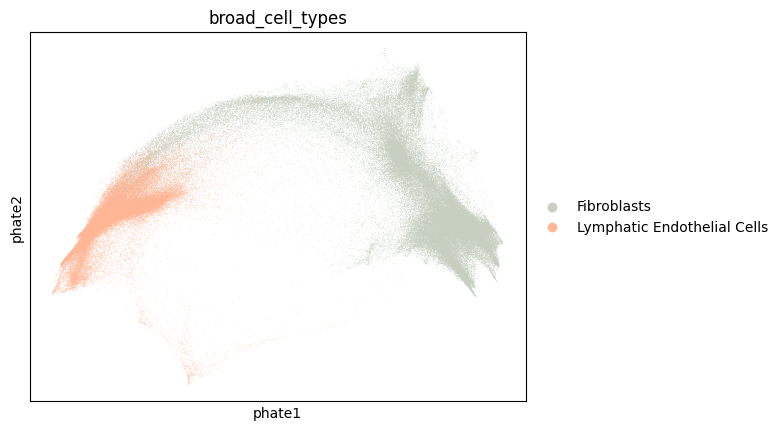

In [39]:
sce.pl.phate(
    adata_subset,
    color='broad_cell_types',
    # show=False
)

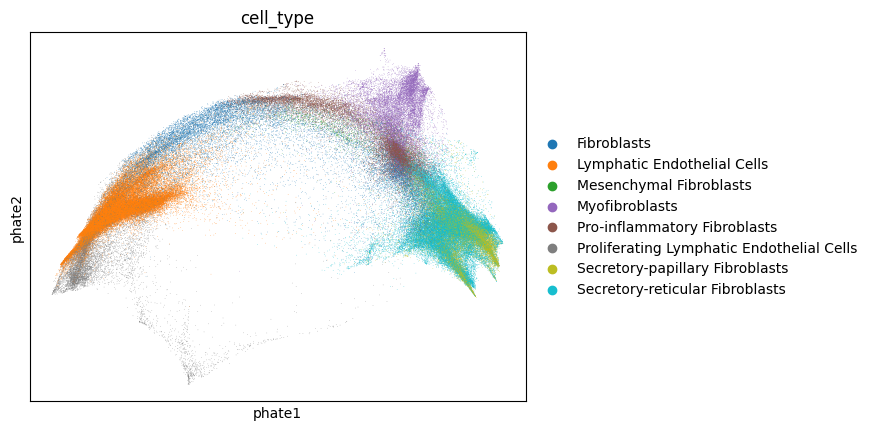

In [40]:
sce.pl.phate(
    adata_subset,
    color='cell_type',
    palette='tab10',
    cmap='tab10'
    # show=False
)

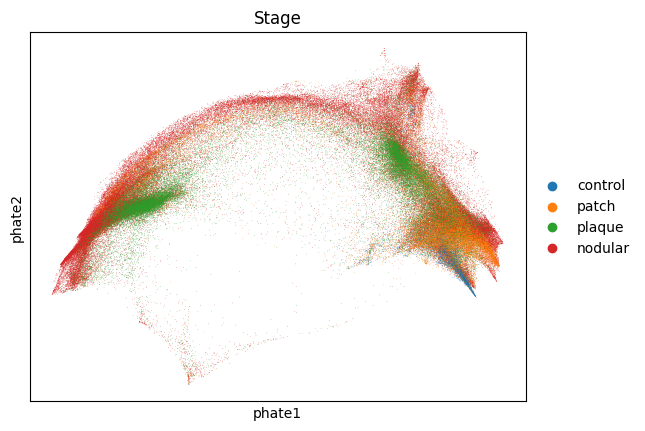

In [41]:
sce.pl.phate(
    adata_subset,
    color='Stage',
    # show=False
)

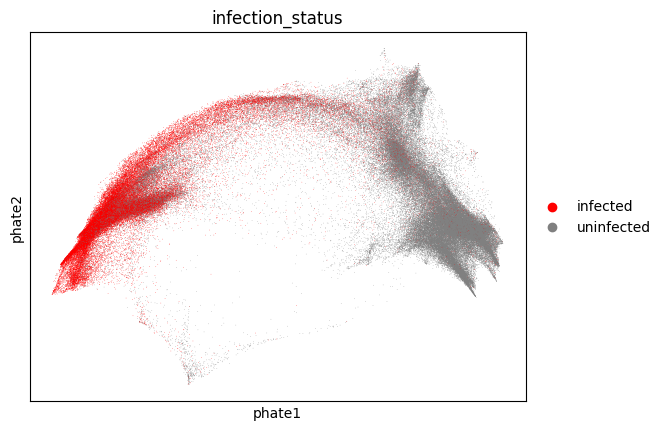

In [42]:
sce.pl.phate(
    adata_subset,
    color='infection_status',
    palette={'infected': 'r', 'uninfected': 'gray'})

In [43]:
%%time

sc.pp.neighbors(adata_subset, n_neighbors=20, random_state=1111)

CPU times: total: 45.1 s
Wall time: 46.1 s


In [44]:
%%time

sc.tl.leiden(
    adata_subset, 
    resolution=0.1,
    random_state=1111,
    
)

CPU times: total: 43.3 s
Wall time: 43.5 s


In [45]:
adata_subset.obs.leiden.nunique()

3

In [46]:
adata_subset.obs.leiden

43         0
44         0
87         0
467        2
475        1
          ..
5786906    0
5786911    0
5786913    1
5786916    0
5787412    0
Name: leiden, Length: 176840, dtype: category
Categories (3, object): ['0', '1', '2']

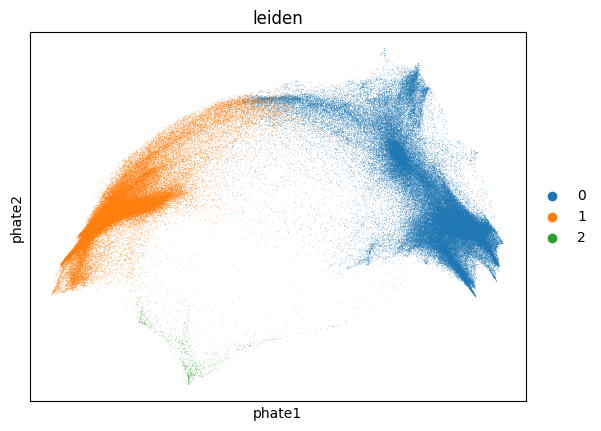

In [47]:
sce.pl.phate(
    adata_subset,
    color='leiden',
    # show=False
)

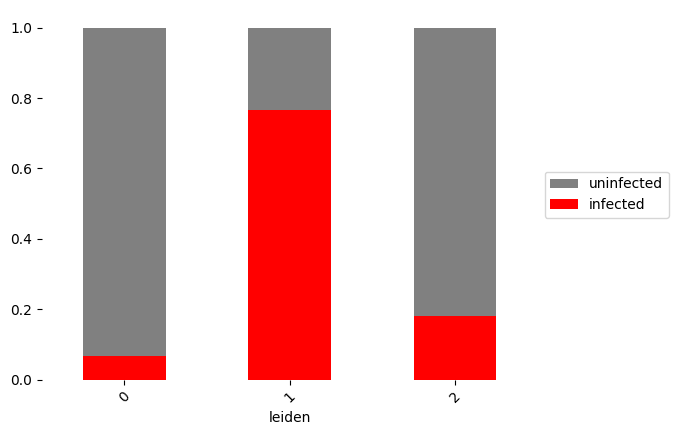

In [48]:
proportion(adata_subset, group_key='leiden', label_key='infection_status', palette={'infected': 'r', 'uninfected': 'gray'})

In [ ]:
proportion(adata_subset, group_key='leiden', label_key='niches', palette=niche_colors)

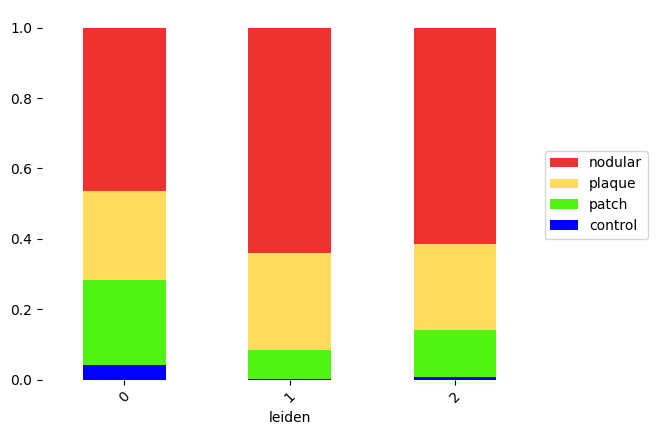

In [50]:
stage_colors = {
    'nodular': '#ed322f',
    'plaque': '#ffdc5e',
    'patch': '#51f512',
    'control': 'blue'
}
proportion(adata_subset, group_key='leiden', label_key='Stage', palette=stage_colors)

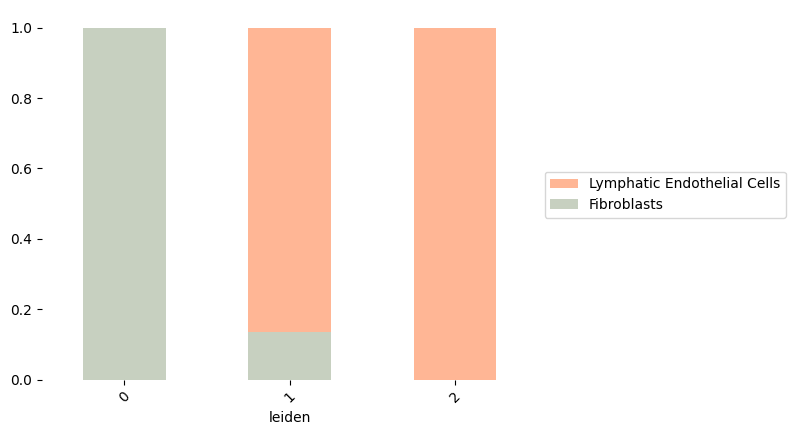

In [51]:
proportion(adata_subset, group_key='leiden', label_key='broad_cell_types', palette=broad_cell_types_color_mapping)

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Calculate angiogenesis_meta
gene_list = ['COL5A2', 'PDGFA', 'ITGAV', 'POSTN']
# Make sure the genes exist in the adata_subset
if all(gene in adata_subset.var_names for gene in gene_list):
    adata_subset.obs['angiogenesis_meta'] = adata_subset[:, gene_list].X.sum(axis=1).A1  # .A1 converts sparse matrix to array
else:
    print("One or more genes are not present in the dataset.")

# Step 2: Ensure infection_status is added to adata_subset
# This is a placeholder. Replace with your actual infection status data.
# Example: adata_subset.obs['infection_status'] = np.random.choice(['Infected', 'Not Infected'], size=adata_subset.n_obs)

# Step 3: Define color mapping for infection status
infection_status_colors = {
    'infected': '#ff0000',  # Red for Infected
    'uninfected': '#D3D3D3'  # Light gray for Not Infected
}

# Set up subplot grid (3 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=150)
axes = axes.flatten()

s = 0.8

# Plot 1: Stage
sce.pl.phate(
    adata_subset,
    color='Stage',
    ax=axes[0],
    show=False, s=s,
    palette=stage_colors
)

# Plot 2: Infection Status
sce.pl.phate(
    adata_subset,
    color='infection_status',
    ax=axes[1],
    show=False, s=s,
    palette=infection_status_colors
)

# Plot 3: Niche with Tumor Proximity
sce.pl.phate(
    adata_subset,
    color='niches',
    ax=axes[2],
    show=False, s=s,
    palette=niche_colors
)

# Plot 4: Angiogenesis Meta
sce.pl.phate(
    adata_subset,
    color='angiogenesis_meta',
    ax=axes[3],
    show=False, s=s,
    palette='viridis'  # or any colormap you prefer
)

# Plot 5: Path Block Core (no palette provided)
sce.pl.phate(
    adata_subset,
    color='leiden',
    ax=axes[4],
    show=False, s=s
)

# Plot 6: Broad Cell Types
sce.pl.phate(
    adata_subset,
    color='cell_type',
    ax=axes[5],
    show=False, s=s,
    palette=sub_cell_types_color_mapping
)

# Finalize
plt.tight_layout()
plt.show()

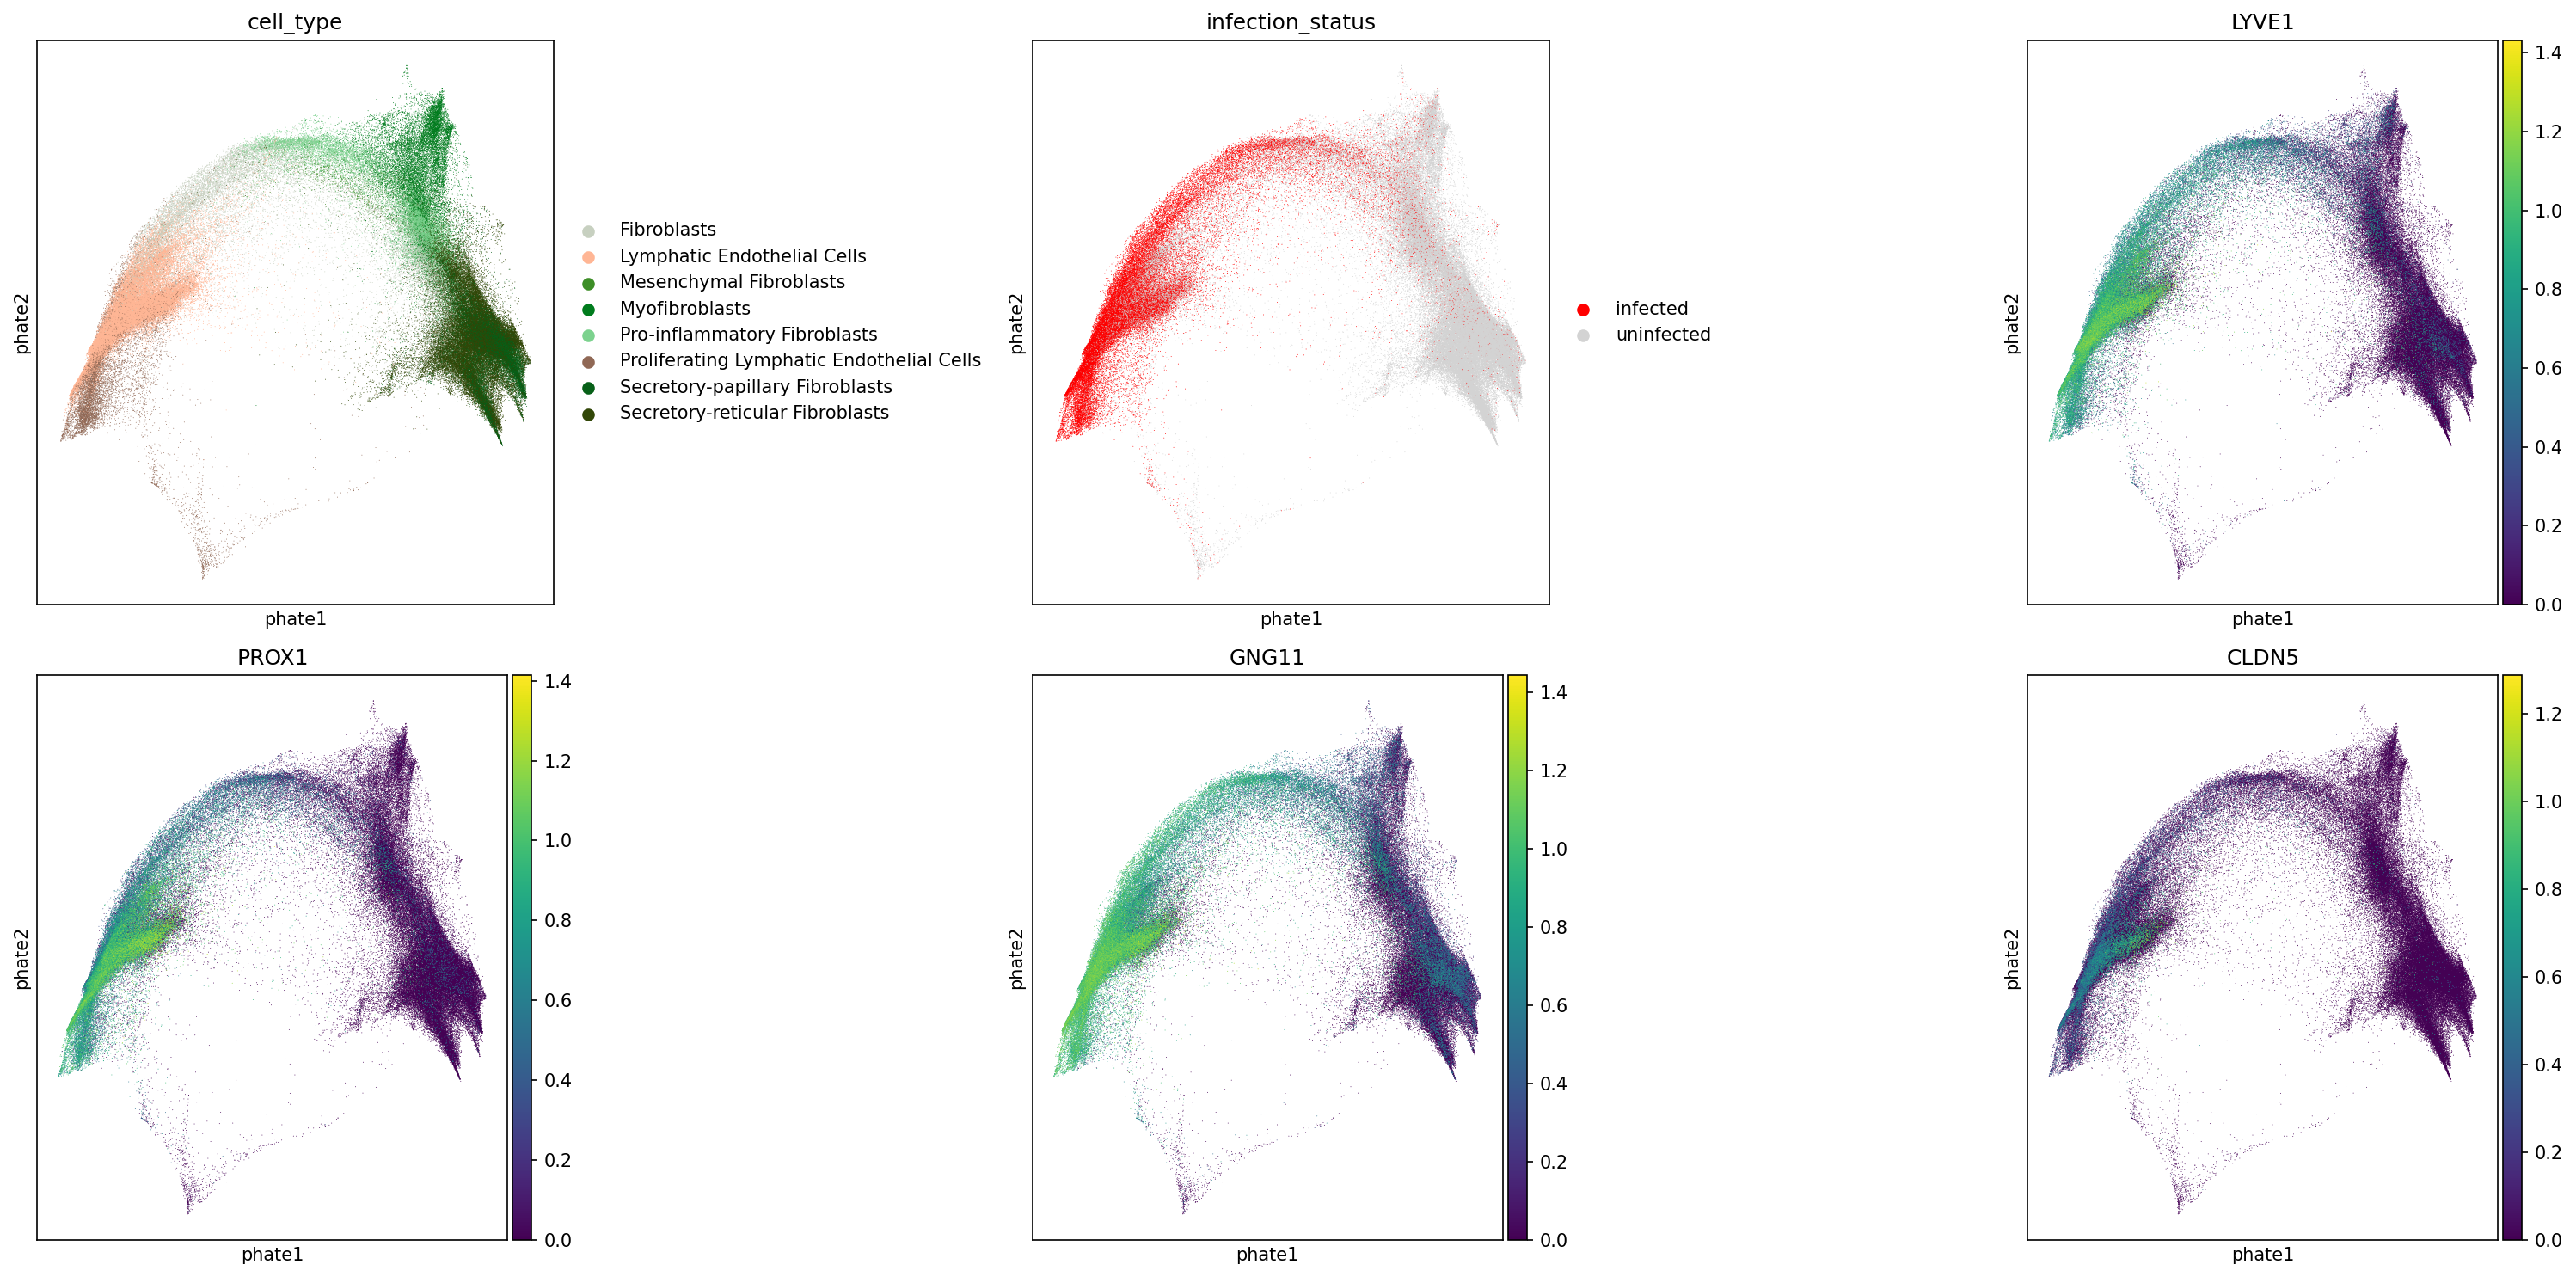

In [53]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Calculate angiogenesis_meta
gene_list = ['COL5A2', 'PDGFA', 'ITGAV', 'POSTN']
# Make sure the genes exist in the adata_subset
if all(gene in adata_subset.var_names for gene in gene_list):
    adata_subset.obs['angiogenesis_meta'] = adata_subset[:, gene_list].X.sum(axis=1).A1  # .A1 converts sparse matrix to array
else:
    print("One or more genes are not present in the dataset.")

# Step 2: Ensure infection_status is added to adata_subset
# This is a placeholder. Replace with your actual infection status data.
# Example: adata_subset.obs['infection_status'] = np.random.choice(['Infected', 'Not Infected'], size=adata_subset.n_obs)

# Step 3: Define color mapping for infection status
infection_status_colors = {
    'infected': '#ff0000',  # Red for Infected
    'uninfected': '#D3D3D3'  # Light gray for Not Infected
}

# Set up subplot grid (3 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=150)
axes = axes.flatten()

s = 0.8

# Plot 1: Stage
sce.pl.phate(
    adata_subset,
    color='cell_type',
    ax=axes[0],
    show=False, s=s,
    palette=sub_cell_types_color_mapping
)

# Plot 2: Infection Status
sce.pl.phate(
    adata_subset,
    color='infection_status',
    ax=axes[1],
    show=False, s=s,
    palette=infection_status_colors
)

# Plot 3: Niche with Tumor Proximity
sce.pl.phate(
    adata_subset,
    color='LYVE1',
    ax=axes[2],
    show=False, s=s,
    palette='viridis'
)

# Plot 4: Angiogenesis Meta
sce.pl.phate(
    adata_subset,
    color='PROX1',
    ax=axes[3],
    show=False, s=s,
    palette='viridis'  # or any colormap you prefer
)

# Plot 5: Path Block Core (no palette provided)
sce.pl.phate(
    adata_subset,
    color='GNG11',
    ax=axes[4],
    show=False, s=s, 
    palette='viridis'
)

# Plot 6: Broad Cell Types
sce.pl.phate(
    adata_subset,
    color='CLDN5',
    ax=axes[5],
    show=False, s=s,
    palette='viridis'
)

# Finalize
plt.tight_layout()
plt.show()

In [25]:
output_prefix = 'fibroblasts_and_LEC'

In [ ]:
adata_subset.write_h5ad(f'data/adata_subset_PHATE_noKSHV_clusters_{output_prefix}.h5ad')

In [ ]:
import pandas as pd

# Extract the expression matrix
expression_matrix = adata_subset.X  # If using a sparse matrix, use .A to convert to dense if needed
# If adata.X is sparse, convert it to a dense format (if it's small enough)
if hasattr(adata_subset.X, 'toarray'):
    expression_matrix = adata_subset.X.toarray()

# Create a DataFrame for the expression matrix
expression_df = pd.DataFrame(expression_matrix, index=adata_subset.obs.index, columns=adata_subset.var.index)

# Save the expression matrix as a CSV file
expression_df.to_csv(f"data/expression_matrix_subset_{output_prefix}.csv", index=True)

In [ ]:
# Extract cell metadata
cell_metadata = adata_subset.obs
cell_metadata.to_csv(f"data/cell_metadata_subset_{output_prefix}.csv", index=True)

# Extract gene metadata
gene_metadata = adata_subset.var
gene_metadata.to_csv(f"data/gene_metadata_subset_{output_prefix}.csv", index=True)

# Extract gene names
gene_names = adata_subset.var.index.tolist()  # Get the gene names
gene_names_df = pd.DataFrame(gene_names, columns=["gene_name"])
gene_names_df.to_csv(f"data/gene_names_subset_{output_prefix}.csv", header=False, index=False)

print("Data extraction complete. Files saved in 'data' directory.")

In [ ]:
import pandas as pd

# Extract PHATE embedding
phate_df = pd.DataFrame(
    adata_subset.obs["leiden"],
    # index=["Cell_" + str(i) for i in adata_subset.obs_names],
    index=adata_subset.obs.index,
    columns=["leiden"]  # Add more if ndim > 2
)

# Save to CSV with index
phate_df.to_csv(f"data/leiden_cluster_ids_{output_prefix}.csv", index=True)


In [ ]:
import pandas as pd

# Extract PHATE embedding
phate_df = pd.DataFrame(
    adata_subset.obsm["X_phate"],
    # index=["Cell_" + str(i) for i in adata_subset.obs_names],
    index=adata_subset.obs.index,
    columns=["PHATE_1", "PHATE_2"]  # Add more if ndim > 2
)

# Save to CSV with index
phate_df.to_csv(f"data/phate_embedding_{output_prefix}.csv", index=True)
